# Data Processing

In [18]:
import pandas as pd

df = pd.read_csv("FPA-FOD_39attributes.csv", low_memory = False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302521 entries, 0 to 2302520
Data columns (total 43 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   FIRE_YEAR               int64  
 2   DISCOVERY_DOY           int64  
 3   FIPS_CODE               float64
 4   Annual_etr              int64  
 5   Annual_precipitation    int64  
 6   Annual_tempreture       float64
 7   pr                      float64
 8   tmmn                    float64
 9   vs                      float64
 10  fm100                   float64
 11  fm1000                  float64
 12  bi                      float64
 13  vpd                     float64
 14  erc                     float64
 15  Elevation_1km           float64
 16  Aspect_1km              float64
 17  Slope_1km               float64
 18  TPI_1km                 float64
 19  Evacuation              float64
 20  SDI                     float64
 21  FRG                     int64  

In [28]:
df = df.drop('Unnamed: 0', axis = 'columns')

unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

for col in X.columns: #convert numeric values to floats, if possible
    if X[col].dtype == 'object':
        # try converting to float — if it works, keep it numeric
        try:
            X[col] = X[col].astype(float)
        except ValueError:
            pass

KeyError: "['Unnamed: 0'] not found in axis"

# K-Means Clustering

In [29]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# Updated numeric features based on your data columns (only using relevant columns you provided)
numeric_features = [
    'pr', 'tmmn', 'Annual_tempreture', 'Annual_precipitation', 'vpd', 'bi', 'erc', 'fm100', 'fm1000',
    'Elevation_1km', 'Slope_1km', 'Aspect_1km', 'TPI_1km',
    'SDI', 'No_FireStation_1.0km', 'GACC_PL', 'GAP_Sts', 'GDP', 'GHM', 'NDVI-1day', 'NPL', 'Popo_1km',
    'road_county_dis', 'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4',
    'erc_Percentile_numeric', 'EVC_1km_count', 'EVC_1km_percent', 'FRG_1km_count', 'FRG_1km_percent',
    'DISCOVERY_DOY', 'FIRE_YEAR'
]

# Updated categorical features (using your categorical columns)
categorical_features = ['Mang_Name']

# Define the preprocessor with imputation and encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [31]:
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

kmeans = KMeans(n_clusters=12, init='k-means++', n_init=20, max_iter=300, random_state=42)
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('kmeans', kmeans)])

In [32]:
from sklearn.model_selection import train_test_split

# Combine X and y into one DataFrame temporarily
df2 = X.copy()
df2['cause'] = y_encoded

X = df2.drop(columns=['cause'])
y = df2['cause']

# Now do your train-test split as usual, making sure there is even representation of causes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.value_counts())

(1363952, 41) (340988, 41)
cause
1     428570
6     261719
0     256885
2     151984
10     79500
5      52760
11     50937
9      29934
8      26097
4      14898
7       8474
3       2194
Name: count, dtype: int64


In [33]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train.value_counts().reset_index()
counts.columns = ['cause_id', 'count']

# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])

print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
        1                  Misuse of fire by a minor 428570
        6        Railroad operations and maintenance 261719
        0                    Debris and open burning 256885
        2                  Equipment and vehicle use 151984
       10                               Other causes  79500
        5 Power generation/transmission/distribution  52760
       11                Firearms and explosives use  50937
        9                                    Smoking  29934
        8                                    Natural  26097
        4                         Arson/incendiarism  14898
        7                    Recreation and ceremony   8474
        3                                  Fireworks   2194


In [34]:
X_train

,FIRE_YEAR,DISCOVERY_DOY,FIPS_CODE,Annual_etr,Annual_precipitation,Annual_tempreture,pr,tmmn,vs,fm100,...,RPL_THEMES,RPL_THEME1,RPL_THEME2,RPL_THEME3,RPL_THEME4,erc_Percentile_numeric,EVC_1km_count,EVC_1km_percent,FRG_1km_count,FRG_1km_percent
945911,1998,261,NaN,1741,583,282.0,0.0,275.500000,4.8,12.4,...,0.1790,0.2700,0.3140,0.0890,0.1680,20.0,25.0,NaN,1.0,NaN
814505,2010,67,37043.0,1548,1142,286.0,0.0,271.299988,2.8,13.5,...,0.6742,0.2780,0.1620,0.2918,0.3875,NaN,355.0,NaN,1.0,NaN
2074799,1994,252,48005.0,1712,1536,292.0,8.6,292.600006,2.9,18.7,...,0.6640,0.6550,0.4340,0.7190,0.6710,5.0,145.0,NaN,1.0,NaN
421807,2014,78,48257.0,2416,764,291.0,0.0,276.700012,5.1,12.4,...,0.9897,0.8866,0.9189,0.8747,0.9891,80.0,25.0,NaN,2.0,NaN
277337,2008,113,16049.0,1509,464,282.0,0.7,269.700012,3.3,13.5,...,0.4790,0.8170,0.5140,0.0280,0.2710,40.0,135.0,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381149,1995,212,NaN,2693,339,291.0,0.0,294.299988,4.1,4.6,...,0.9620,0.8440,0.8290,0.9470,0.9160,NaN,228.0,NaN,5.0,NaN
1908753,1999,214,28003.0,1871,1257,290.0,0.0,294.299988,3.6,14.7,...,0.5220,0.6490,0.4460,0.7390,0.3420,80.0,64.0,NaN,5.0,NaN
193016,2018,111,47067.0,1396,1626,287.0,0.0,276.299988,2.4,13.1,...,0.7735,0.8438,0.8011,0.0271,0.9104,80.0,175.0,NaN,1.0,NaN
931514,1998,210,NaN,1172,1655,284.0,0.0,289.399994,2.9,11.5,...,0.3980,0.4050,0.3730,0.5240,0.3750,40.0,169.0,NaN,5.0,NaN


In [35]:
y_train

945911     5
814505     1
2074799    1
421807     1
277337     0
          ..
381149     0
1908753    0
193016     1
931514     6
177885     0
Name: cause, Length: 1363952, dtype: int64

In [36]:
model.fit(X_train, y_train)

/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


,steps,"[('preprocessor', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
y_pred = model.predict(X_test)

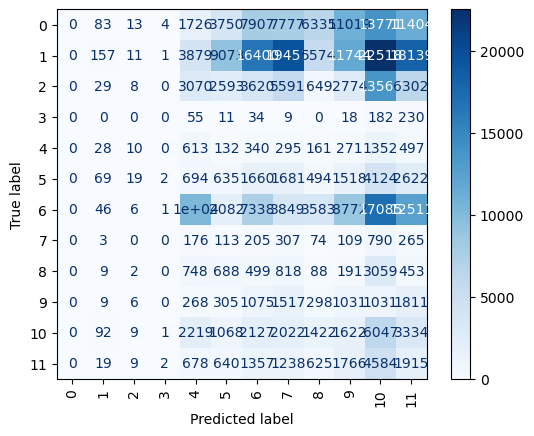

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')

plt.savefig('Kmeans_cm.png')
plt.show()

In [39]:
from sklearn.metrics import accuracy_score
from scipy.stats import mode
import numpy as np

# Map each cluster label to the most frequent true label in that cluster (using training set info)
def map_clusters_to_labels(y_true, y_clusters):
    labels = np.zeros_like(y_clusters)
    for cluster in np.unique(y_clusters):
        mask = (y_clusters == cluster)
        cluster_labels = np.array(y_true)[mask] 
        m = mode(cluster_labels) #Which true class label occurs most frequently in this cluster?
        # Handle scalar or array-like output
        if hasattr(m.mode, "__iter__"):
            labels[mask] = m.mode[0]
        else:
            labels[mask] = m.mode
    return labels

# Apply mapping
y_pred_mapped = map_clusters_to_labels(y_test.values, y_pred)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred_mapped)
print(f'KMeans Clustering Accuracy: {acc:.4f}')

KMeans Clustering Accuracy: 0.3347


In [40]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    matthews_corrcoef
)

# y_test: true labels; y_pred: predicted labels (can be mapped as in your earlier code)

# Accuracy
accuracy = accuracy_score(y_test, y_pred_mapped)

# Precision, Recall, F1 (macro averages for multiclass)
precision = precision_score(y_test, y_pred_mapped, average='macro')
recall = recall_score(y_test, y_pred_mapped, average='macro')
f1 = f1_score(y_test, y_pred_mapped, average='macro')

# Cohen's Kappa
cohen_kappa = cohen_kappa_score(y_test, y_pred_mapped)

# Matthew’s Correlation Coefficient
matthews_corr = matthews_corrcoef(y_test, y_pred_mapped)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")
print(f"F1 Score (macro): {f1:.4f}")
print(f"Cohen’s Kappa: {cohen_kappa:.4f}")
print(f"Matthew’s Correlation Coefficient: {matthews_corr:.4f}")


Accuracy: 0.3347
Precision (macro): 0.1068
Recall (macro): 0.0974
F1 Score (macro): 0.0722
Cohen’s Kappa: 0.0526
Matthew’s Correlation Coefficient: 0.0852


/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
